# [**La borne de Johnson-Lindenstrauss pour l'incorporation avec des projections aléatoires**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/misc/plot_johnson_lindenstrauss_bound.ipynb)<br/>([*The Johnson-Lindenstrauss bound for embedding with random projections*](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_johnson_lindenstrauss_bound.html))

Le [lemme de Johnson-Lindenstrauss](https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma) stipule que tout ensemble de données de grande dimension peut être projeté de manière aléatoire dans un espace euclidien de dimension inférieure tout en contrôlant la distorsion dans les distances par paires.

In [2]:
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.random_projection import SparseRandomProjection
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.datasets import load_digits
from sklearn.metrics.pairwise import euclidean_distances

# Les limites théoriques :

La distorsion introduite par une projection aléatoire $p$ est attestée par le fait que $p$ définit une `eps`-incorporation avec une bonne probabilité comme défini par :

$$
(1 - eps) \|u - v\|^2 < \|p(u) - p(v)\|^2 < (1 + eps) \|u - v\|^2
$$

Où $u$ et $v$ sont des lignes prises dans un ensemble de données de forme `(n_samples, n_features)` et $p$ est une projection par une matrice gaussienne aléatoire $\mathcal{N}(0,1)$ de forme `(n_components, n_features)` (ou une matrice creuse d'Achlioptas).

Le nombre minimum de composants pour garantir l'`eps`-incorporation est donné par :

$$
n_\text{components} \geq 4 \log(n_\text{samples}) / (eps^2 / 2 - eps^3 / 3)
$$

Le premier graphique montre qu'avec un nombre croissant d'échantillons n_samples, le nombre minimal de dimensions `n_components` augmente logarithmiquement afin de garantir une `eps`-incorporation.

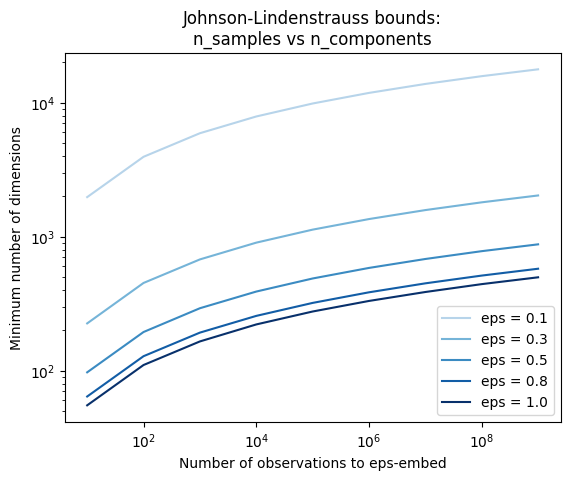

In [3]:
# range of admissible distortions
eps_range = np.linspace(0.1, 0.99, 5)
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(eps_range)))

# range of number of samples (observation) to embed
n_samples_range = np.logspace(1, 9, 9)

plt.figure()
for eps, color in zip(eps_range, colors):
    min_n_components = johnson_lindenstrauss_min_dim(n_samples_range, eps=eps)
    plt.loglog(n_samples_range, min_n_components, color=color)

plt.legend([f"eps = {eps:0.1f}" for eps in eps_range], loc="lower right")
plt.xlabel("Number of observations to eps-embed")
plt.ylabel("Minimum number of dimensions")
plt.title("Johnson-Lindenstrauss bounds:\nn_samples vs n_components")
plt.show()

Le deuxième graphique montre qu'une augmentation de la distorsion admissible `eps` permet de réduire drastiquement le nombre minimal de dimensions `n_components` pour un nombre donné d'échantillons `n_samples`.

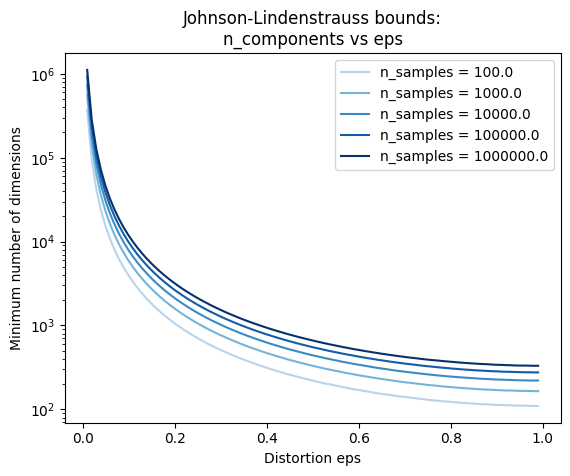

In [4]:
# range of admissible distortions
eps_range = np.linspace(0.01, 0.99, 100)

# range of number of samples (observation) to embed
n_samples_range = np.logspace(2, 6, 5)
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(n_samples_range)))

plt.figure()
for n_samples, color in zip(n_samples_range, colors):
    min_n_components = johnson_lindenstrauss_min_dim(n_samples, eps=eps_range)
    plt.semilogy(eps_range, min_n_components, color=color)

plt.legend([f"n_samples = {n}" for n in n_samples_range], loc="upper right")
plt.xlabel("Distortion eps")
plt.ylabel("Minimum number of dimensions")
plt.title("Johnson-Lindenstrauss bounds:\nn_components vs eps")
plt.show()

# Validation empirique :

Nous validons les limites ci-dessus sur le jeu de données de documents textuels 20 newsgroups (fréquences de mots TF-IDF) ou sur le jeu de données des chiffres :
* pour le jeu de données 20 newsgroups, environ 300 documents avec 100k caractéristiques au total sont projetés à l'aide d'une matrice creuse aléatoire sur des espaces euclidiens plus petits avec différentes valeurs pour le nombre cible de dimensions `n_components`.
* pour le jeu de données des chiffres, des données de niveaux de gris 8x8 pixels pour 300 images de chiffres manuscrits sont projetées de manière aléatoire dans des espaces pour différents nombres de dimensions `n_components` plus grands.

Le jeu de données par défaut est le jeu de données 20 newsgroups. Pour exécuter l'exemple sur le jeu de données des chiffres, passez l'argument de ligne de commande `--use-digits-dataset` à ce script.

In [5]:
if "--use-digits-dataset" in sys.argv:
    data = load_digits().data[:300]
else:
    data = fetch_20newsgroups_vectorized().data[:300]

Pour chaque valeur de `n_components`, nous traçons :
* la distribution 2D des paires d'échantillons avec des distances par paires dans des espaces d'origine et projetés comme axe x et y respectivement.
* l'histogramme 1D du rapport de ces distances (projetées / d'origine).

Embedding 300 samples with dim 130107 using various random projections
Projected 300 samples from 130107 to 300 in 0.407s
Random matrix with size: 1.301 MB
Mean distances rate: 1.02 (0.20)
Projected 300 samples from 130107 to 1000 in 1.522s
Random matrix with size: 4.331 MB
Mean distances rate: 1.01 (0.10)
Projected 300 samples from 130107 to 10000 in 10.418s
Random matrix with size: 43.314 MB
Mean distances rate: 0.98 (0.03)


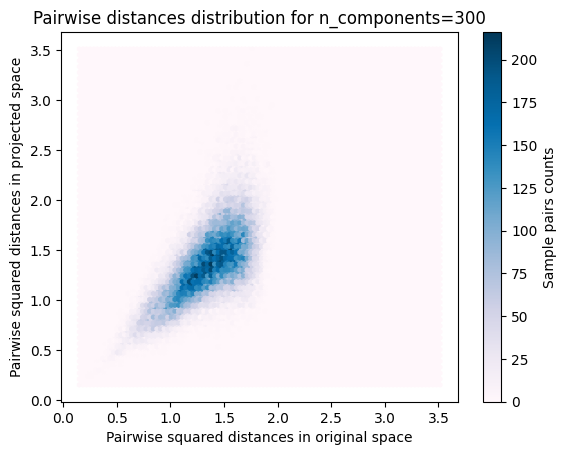

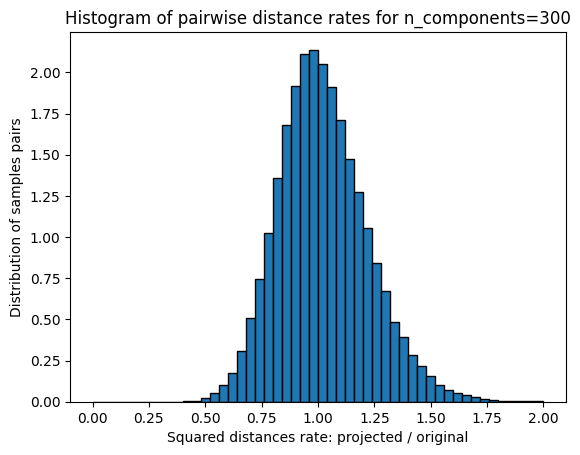

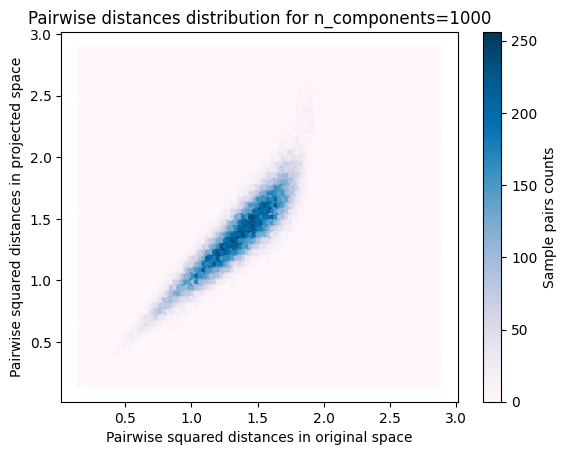

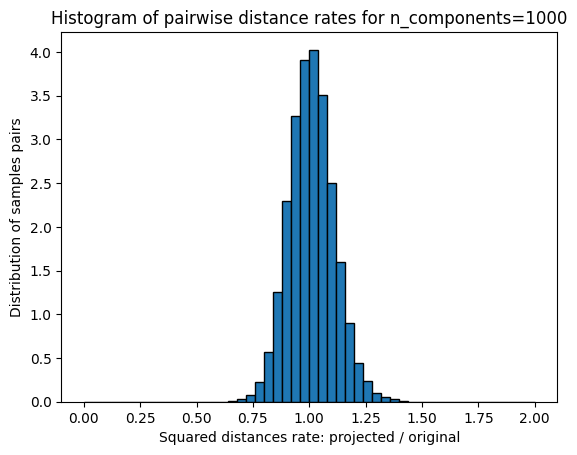

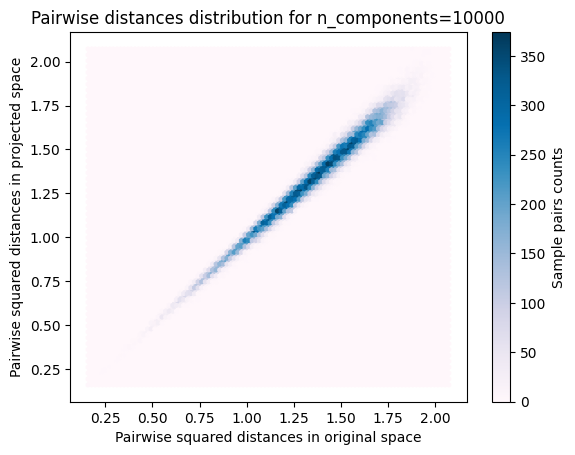

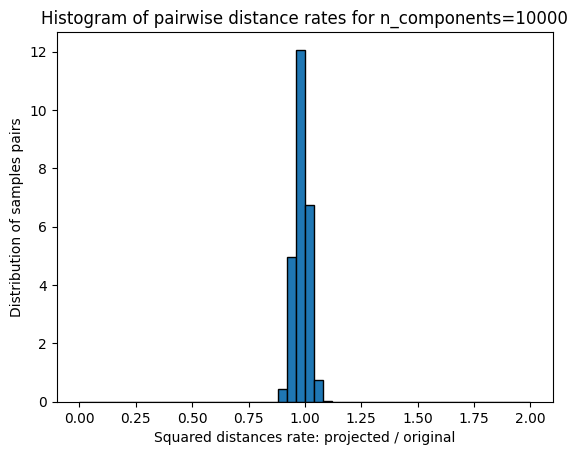

In [6]:
n_samples, n_features = data.shape
print(
    f"Embedding {n_samples} samples with dim {n_features} using various "
    "random projections"
)

n_components_range = np.array([300, 1_000, 10_000])
dists = euclidean_distances(data, squared=True).ravel()

# select only non-identical samples pairs
nonzero = dists != 0
dists = dists[nonzero]

for n_components in n_components_range:
    t0 = time()
    rp = SparseRandomProjection(n_components=n_components)
    projected_data = rp.fit_transform(data)
    print(
        f"Projected {n_samples} samples from {n_features} to {n_components} in "
        f"{time() - t0:0.3f}s"
    )
    if hasattr(rp, "components_"):
        n_bytes = rp.components_.data.nbytes
        n_bytes += rp.components_.indices.nbytes
        print(f"Random matrix with size: {n_bytes / 1e6:0.3f} MB")

    projected_dists = euclidean_distances(projected_data, squared=True).ravel()[nonzero]

    plt.figure()
    min_dist = min(projected_dists.min(), dists.min())
    max_dist = max(projected_dists.max(), dists.max())
    plt.hexbin(
        dists,
        projected_dists,
        gridsize=100,
        cmap=plt.cm.PuBu,
        extent=[min_dist, max_dist, min_dist, max_dist],
    )
    plt.xlabel("Pairwise squared distances in original space")
    plt.ylabel("Pairwise squared distances in projected space")
    plt.title("Pairwise distances distribution for n_components=%d" % n_components)
    cb = plt.colorbar()
    cb.set_label("Sample pairs counts")

    rates = projected_dists / dists
    print(f"Mean distances rate: {np.mean(rates):.2f} ({np.std(rates):.2f})")

    plt.figure()
    plt.hist(rates, bins=50, range=(0.0, 2.0), edgecolor="k", density=True)
    plt.xlabel("Squared distances rate: projected / original")
    plt.ylabel("Distribution of samples pairs")
    plt.title("Histogram of pairwise distance rates for n_components=%d" % n_components)

    # TODO: compute the expected value of eps and add them to the previous plot
    # as vertical lines / region

plt.show()

Nous pouvons voir que pour de faibles valeurs de `n_components`, la distribution est large avec de nombreuses paires déformées et une distribution biaisée (en raison de la limite rigide du rapport nul à gauche car les distances sont toujours positives), tandis que pour des valeurs plus élevées de `n_components`, la distorsion est contrôlée et les distances sont bien préservées par la projection aléatoire.

# Remarques

Selon le lemme JL, la projection de 300 échantillons sans trop de distorsion nécessitera plusieurs milliers de dimensions, indépendamment du nombre de caractéristiques de l'ensemble de données d'origine.

Ainsi, l'utilisation de projections aléatoires sur le jeu de données des chiffres, qui n'a que 64 caractéristiques dans l'espace d'entrée, n'a pas de sens : cela n'autorise pas la réduction de la dimensionnalité dans ce cas.

En revanche, pour les 20 newsgroups, la dimensionnalité peut être réduite de 56 436 à 10 000 tout en préservant raisonnablement les distances par paires.